# Importing ressources

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [2]:
df_train = pd.read_csv("data/stores_train.csv")
df_test = pd.read_csv("data/stores_test.csv")
df_bus_stops = pd.read_csv("data/busstops_norway_fixed.csv")
df_grunnkrets_age_dist = pd.read_csv("data/grunnkrets_age_distribution.csv")
df_grunnkrets_house_pers = pd.read_csv("data/grunnkrets_households_num_persons.csv")
df_grunnkrets_income_house = pd.read_csv("data/grunnkrets_income_households.csv")
df_grunnkrets_stripped = pd.read_csv("data/grunnkrets_norway_stripped.csv")
df_plaace_hierarchy = pd.read_csv("data/plaace_hierarchy.csv")
df_extra = pd.read_csv("data/stores_extra.csv")

In [3]:
df_grunnkrets_stripped = df_grunnkrets_stripped[df_grunnkrets_stripped.year == 2016]
df_grunnkrets_age_dist = df_grunnkrets_age_dist[df_grunnkrets_age_dist.year == 2016]
df_grunnkrets_house_pers = df_grunnkrets_house_pers[df_grunnkrets_house_pers.year == 2016]
df_grunnkrets_income_house = df_grunnkrets_income_house[df_grunnkrets_income_house.year == 2016]

In [4]:
def rmsle(y_true, y_pred):
    """
    Computes the Root Mean Squared Logarithmic Error 
    
    Args:
        y_true (np.array): n-dimensional vector of ground-truth values 
        y_pred (np.array): n-dimensional vecotr of predicted values 
    
    Returns:
        A scalar float with the rmsle value 
    
    Note: You can alternatively use sklearn and just do: 
        `sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5`
    """
    assert (y_true >= 0).all(), 'Received negative y_true values'
    assert (y_pred >= 0).all(), 'Received negative y_pred values'
    assert y_true.shape == y_pred.shape, 'y_true and y_pred have different shapes'
    y_true_log1p = np.log1p(y_true)  # log(1 + y_true)
    y_pred_log1p = np.log1p(y_pred)  # log(1 + y_pred)
    return np.sqrt(np.mean(np.square(y_pred_log1p - y_true_log1p)))

# Pipeline

In [5]:
def label_uniformier(array_train, array_test):
    """
    Take the unique values from the train and test part to combine it in a single array.
    Useful to fit the label encoder and don't do a mess during the transform (previously fit_transform that was confusing)
    """
    label_encoder = LabelEncoder()
    labels = np.asarray(list(array_train.unique()) + list(set(array_test.unique()) - set(array_train.unique())))
    label_encoder.fit(labels)
    return label_encoder

In [6]:
def create_population_age():
    df_grunnkrets_population = df_grunnkrets_age_dist.loc[:, ['grunnkrets_id']]
    df_grunnkrets_population['total_population'] = df_grunnkrets_age_dist.iloc[:,2:92].sum(axis=1)
    df_grunnkrets_population['youngs'] = df_grunnkrets_age_dist.iloc[:,2:20].sum(axis=1)
    df_grunnkrets_population['adults'] = df_grunnkrets_age_dist.iloc[:,21:64].sum(axis=1)
    df_grunnkrets_population['seniors'] = df_grunnkrets_age_dist.iloc[:,65:92].sum(axis=1)
    return df_grunnkrets_population

In [7]:
def create_population_repartition():
    return df_grunnkrets_house_pers[['grunnkrets_id', 'couple_children_0_to_5_years', 'couple_children_6_to_17_years', 'couple_children_18_or_above', 'couple_without_children', 'single_parent_children_0_to_5_years', 'single_parent_children_6_to_17_years', 'single_parent_children_18_or_above', 'singles']]

In [8]:
def create_income_repartition():
        return df_grunnkrets_income_house[['grunnkrets_id', 'all_households']]

In [9]:
def create_municipalities():
    return df_grunnkrets_stripped[["grunnkrets_id", "municipality_name"]]

In [11]:
def impute_municipalities(data):
    data_mun = data[data["municipality_name"].isna()]
    data1 = data
    data = data.drop(data[data.municipality_name.isna()].index)
    data = data.reset_index(drop=True)
    
    for index, row in data_mun.iterrows():
        
        df = pd.DataFrame()
        df["lat1"] = data.loc[:, ["lat"]] - row.lat
        df["lon1"] = data.loc[:, ["lon"]] - row.lon
        print(df)
        dist = np.linalg.norm(df.to_numpy(), axis=1)
        idx = np.argmin(dist)
        #data1["municipality_name"][index] = data["municipality_name"][idx]
        data1.loc[index, "municipality_name"] = data.loc[idx, "municipality_name"]
        #data1 = data1.replace(data1["municipality_name"][index], data["municipality_name"][idx])
        #print(data1["municipality_name"][index])
 
    return data1

In [12]:
#train
X_train = df_train.loc[:, ['grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', "mall_name", 'plaace_hierarchy_id']]
X_test = df_test.loc[:, ['grunnkrets_id', 'lat', 'lon', 'sales_channel_name', 'chain_name', "mall_name", 'plaace_hierarchy_id']]

X_train['lat'] = X_train.lat * 11.112
X_train['lon'] = X_train.lon * 6.4757
X_test['lat'] = X_test.lat * 11.112
X_test['lon'] = X_test.lon * 6.4757


X_train = pd.merge(X_train, df_grunnkrets_stripped[['grunnkrets_id', 'area_km2']], how="left", on="grunnkrets_id")
X_test = pd.merge(X_test, df_grunnkrets_stripped[['grunnkrets_id', 'area_km2']], how="left", on="grunnkrets_id")

X_train = pd.merge(X_train, df_plaace_hierarchy[['plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']], how='left', on='plaace_hierarchy_id')
X_test = pd.merge(X_test, df_plaace_hierarchy[['plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc']], how='left', on='plaace_hierarchy_id')

""" TEST """
X_train = pd.merge(X_train, create_municipalities(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_municipalities(), how='left', on='grunnkrets_id')

#X_train = pd.merge(X_train, create_population_repartition(), how='left', on='grunnkrets_id')
#X_test = pd.merge(X_test, create_population_repartition(), how='left', on='grunnkrets_id')

X_train = pd.merge(X_train, create_population_age(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_population_age(), how='left', on='grunnkrets_id')

X_train = pd.merge(X_train, create_income_repartition(), how='left', on='grunnkrets_id')
X_test = pd.merge(X_test, create_income_repartition(), how='left', on='grunnkrets_id')
""" TEST """

#sales channel name encoding
le = label_uniformier(X_train['sales_channel_name'], X_test['sales_channel_name'])
X_train['encoded_channel_name'] = le.transform(X_train['sales_channel_name'])
X_test['encoded_channel_name'] = le.transform(X_test['sales_channel_name'])

#municipality imputing + encoding
X_train = impute_municipalities(X_train)
X_test = impute_municipalities(X_test)
le = label_uniformier(X_train['municipality_name'], X_test['municipality_name'])
X_train['municipality_encoded'] = le.transform(X_train['municipality_name'])
X_test['municipality_encoded'] = le.transform(X_test['municipality_name'])


#mall name encoding
X_train['mall_name'] = X_train['mall_name'].fillna('0')
X_test['mall_name'] = X_test['mall_name'].fillna('0')

le = label_uniformier(X_train['mall_name'], X_test['mall_name'])
X_train['encoded_mall'] = le.transform(X_train['mall_name'])
X_test['encoded_mall'] = le.transform(X_test['mall_name'])

#chain name encoding
X_train['chain_name'] = X_train['chain_name'].fillna('0')
X_test['chain_name'] = X_test['chain_name'].fillna('0')

le = label_uniformier(X_train['chain_name'], X_test['chain_name'])
X_train['encoded_chain'] = le.transform(X_train['chain_name'])
X_test['encoded_chain'] = le.transform(X_test['chain_name'])

#hierarchy encoding
le = label_uniformier(df_plaace_hierarchy['lv3_desc'], df_plaace_hierarchy['lv3_desc'])
X_train['encoded_lv3'] = le.transform(X_train['lv3_desc'])
X_test['encoded_lv3'] = le.transform(X_test['lv3_desc'])

le = label_uniformier(df_plaace_hierarchy['lv4_desc'], df_plaace_hierarchy['lv4_desc'])
X_train['encoded_lv4'] = le.transform(X_train['lv4_desc'])
X_test['encoded_lv4'] = le.transform(X_test['lv4_desc'])


""" TRY """
X_train["population_density"] = X_train["total_population"] / X_train["area_km2"]
X_test["population_density"] = X_test["total_population"] / X_test["area_km2"]
#X_train.drop(["area_km2", "total_population"], axis=1)
#X_test.drop(["area_km2", "total_population"], axis=1)

""" TRY """

X_train = X_train.drop(['sales_channel_name', 'chain_name', "mall_name", "municipality_name", 'plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc', "encoded_lv4", "total_population", "area_km2", "youngs", "adults", "seniors"], axis=1)
X_test = X_test.drop(['sales_channel_name', 'chain_name', "mall_name", "municipality_name", 'plaace_hierarchy_id', 'lv1_desc', 'lv2_desc', 'lv3_desc', 'lv4_desc', "encoded_lv4", "total_population", "area_km2", "youngs", "adults", "seniors"], axis=1)

#X_train = X_train.drop(["lat", "lon"], axis=1)
#X_test = X_test.drop(["lat", "lon"], axis=1)

X_train = X_train.apply(lambda x: x.fillna(x.mean()),axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.mean()),axis=0)

scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

Y_train = df_train.loc[:, ['revenue', ]]
Y_train = np.log10(Y_train + 1)
Y_train = scaler.fit_transform(Y_train)

X_train

             lat1       lon1
0       18.744001  16.161407
1       20.640324  19.587718
2       23.429337  16.483430
3      102.534756  43.196602
4       58.913479  17.261658
...           ...        ...
12824   15.112287  17.948971
12825   30.488125  19.326126
12826   21.004831  21.359655
12827    8.822733 -12.780138
12828  129.056361  73.391905

[12829 rows x 2 columns]
             lat1       lon1
0       12.711547   7.390156
1       14.607869  10.816467
2       17.396883   7.712180
3       96.502301  34.425351
4       52.881024   8.490407
...           ...        ...
12824    9.079832   9.177720
12825   24.455671  10.554875
12826   14.972376  12.588404
12827    2.790279 -21.551389
12828  123.023906  64.620654

[12829 rows x 2 columns]
             lat1       lon1
0        4.328503  15.919352
1        6.224825  19.345664
2        9.013839  16.241376
3       88.119257  42.954547
4       44.497980  17.019603
...           ...        ...
12824    0.696789  17.706916
12825   16.072627  1

           lat1       lon1
0      0.191958  36.734386
1     -7.666505  28.971393
2      0.786154  37.624746
3     39.218555  34.623695
4      0.330073  36.722031
...         ...        ...
8545  -7.020809   1.369176
8546 -10.169462   3.931824
8547   0.410391  39.170358
8548   6.160410   0.305697
8549  -8.817308  25.521448

[8550 rows x 2 columns]
           lat1       lon1
0     18.790055  16.287647
1     10.931592   8.524654
2     19.384251  17.178007
3     57.816652  14.176956
4     18.928170  16.275292
...         ...        ...
8545  11.577289 -19.077562
8546   8.428635 -16.514915
8547  19.008488  18.723620
8548  24.758507 -20.141042
8549   9.780789   5.074709

[8550 rows x 2 columns]


,grunnkrets_id,lat,lon,all_households,encoded_channel_name,municipality_encoded,encoded_mall,encoded_chain,encoded_lv3,population_density
0,-0.573259,-0.495375,0.055228,-0.770781,-0.353536,-1.410067,2.076420,1.639203,-0.426722,-0.255028
1,-1.093241,-0.437829,0.194707,-1.035570,-0.353536,0.322596,-0.381280,1.639203,-0.426722,0.000000
2,-0.568111,-0.353193,0.068337,-1.333595,-0.353536,0.459160,1.756919,0.014829,-0.426722,-0.122104
3,1.503184,2.047340,1.155784,-0.822853,-0.353536,-1.512490,1.158879,0.014829,-0.426722,0.148159
4,1.153761,0.723608,0.100017,1.721998,-0.353536,1.235871,3.534655,0.014829,-0.426722,0.000000
...,...,...,...,...,...,...,...,...,...,...
12854,-0.402165,-0.605583,0.127997,-0.956909,-1.810146,-0.641891,-0.381280,-0.540603,-2.401172,0.168690
12855,-0.745993,-0.138987,0.184058,-1.952912,-1.810146,-0.966232,0.585415,0.968494,-2.401172,0.013530
12856,-1.214082,-0.426768,0.266840,-0.311002,-1.810146,0.732289,3.379001,0.968494,-2.401172,0.558473
12857,0.290468,-0.796446,-1.122932,-0.951369,-1.810146,0.621331,0.511684,-0.540603,-2.401172,0.458494


In [ ]:
#change bus stop: find amount of bus stops in 500m distance to shop 
#change lat/long: create areas or use municipality name
#find representative vaildation set
#k fold for hyperparameter tuning
#weighted average and log averages
#maybe more features

In [13]:
X_train, X_train_test, Y_train, Y_train_test = train_test_split(X_train, Y_train)

# Sorting the data by revenue for a better plot, but it mess up with the prediction :(
# X_train_test['revenue'] = Y_train_test
# X_train_test = X_train_test.sort_values('revenue')
# Y_train_test = X_train_test['revenue']
# X_train_test = X_train_test.drop('revenue', axis=1)

# Models

In [195]:
model1 = RandomForestRegressor(
    n_estimators=150,
    criterion='absolute_error',
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    max_leaf_nodes=300,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)
# -> performance: 0.72

In [190]:
model2 = AdaBoostRegressor(
    n_estimators=100,
    learning_rate=0.0001,
    random_state=42
)
#performance: 0.80

In [37]:
model3 = GradientBoostingRegressor(
    learning_rate=0.064312,
    n_estimators=1000,
    subsample=1.0, 
    criterion='squared_error', 
    min_samples_split=4, 
    min_samples_leaf=2, 
    min_weight_fraction_leaf=0.0, 
    max_depth=9, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=42, 
    max_features=None,
    alpha=0.9,
    verbose=0,
    max_leaf_nodes=20,
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
    ccp_alpha=0.0
)
#performance: 0.73

In [38]:
model3.fit(X_train, np.ravel(Y_train))
model3_pred = model3.predict(X_test)

In [137]:
model4 = lgb.LGBMRegressor(
    num_leaves=70,
    max_depth=7, 
    random_state=42,  
    n_estimators=2000,
    min_data_in_leaf = 400,
    learning_rate=0.05
)
#performance: 0.714
#without lat/lon but with municipality: 0.717

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

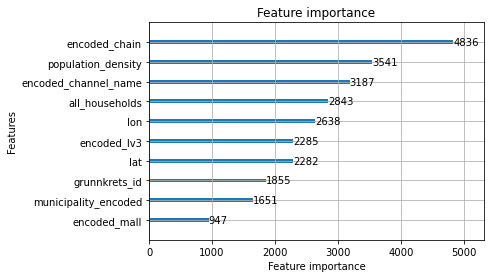

In [147]:
model4.fit(X_train, np.ravel(Y_train))
model4_pred = model4.predict(X_test)
lgb.plot_importance(model4)

In [202]:
model5 = CatBoostRegressor(
    learning_rate=0.1,
    depth = 10,
    iterations = 100,
    random_seed=42,
)
performance: 0.728

In [197]:
model6 = XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=300, 
    random_state=42,
    colsample_bytree=0.8958238323555624, 
    gamma=0.11909139052336326,
    learning_rate=0.05983241782780355,
    subsample=0.8889067727422637,
    max_depth=5,
)
#performance: 0.71

In [198]:
#Random Forest
model1.fit(X_train, np.ravel(Y_train))
model1_pred = model1.predict(X_test)

#AdaBoost
#model2.fit(X_train, np.ravel(Y_train))
#model2_pred = model2.predict(X_test)

#GradientBoost
#model3.fit(X_train, np.ravel(Y_train))
#model3_pred = model3.predict(X_test)

#LGB
model4.fit(X_train, np.ravel(Y_train))
model4_pred = model4.predict(X_test)

#CatBoost
model5.fit(X_train, np.ravel(Y_train))
model5_pred = model5.predict(X_test)

#XGBoost
model6.fit(X_train, np.ravel(Y_train))
model6_pred = model6.predict(X_test)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400


C:\Users\janni\anaconda3\envs\scipy\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [205]:
avg_prediction = np.mean([
    model1_pred,
    #model2_pred,
    #model3_pred,
    model4_pred,
    model5_pred,
    model6_pred], axis=0)

# Hyperparameters

In [28]:
from scipy.stats import loguniform
from sklearn.ensemble import GradientBoostingRegressor

param_distributions = {'depth': [6,8,10],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [30, 50, 100]
}

search_cv = RandomizedSearchCV(
    CatBoostRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2,
)
search_cv.fit(X_train,np.ravel(Y_train))

columns = [f"param_{name}" for name in param_distributions.keys()]
columns += ["mean_test_error", "std_test_error"]
cv_results = pd.DataFrame(search_cv.cv_results_)
cv_results["mean_test_error"] = -cv_results["mean_test_score"]
cv_results["std_test_error"] = cv_results["std_test_score"]
cv_results[columns].sort_values(by="mean_test_error")

0:	learn: 0.9683301	total: 159ms	remaining: 15.7s
1:	learn: 0.9370093	total: 184ms	remaining: 9.04s
2:	learn: 0.9114243	total: 210ms	remaining: 6.8s
3:	learn: 0.8872392	total: 237ms	remaining: 5.68s
4:	learn: 0.8669377	total: 263ms	remaining: 5s
5:	learn: 0.8530973	total: 289ms	remaining: 4.53s
6:	learn: 0.8394425	total: 316ms	remaining: 4.19s
7:	learn: 0.8267521	total: 342ms	remaining: 3.94s
8:	learn: 0.8149307	total: 371ms	remaining: 3.75s
9:	learn: 0.8060981	total: 403ms	remaining: 3.62s
10:	learn: 0.7991595	total: 433ms	remaining: 3.5s
11:	learn: 0.7916822	total: 461ms	remaining: 3.38s
12:	learn: 0.7856429	total: 486ms	remaining: 3.25s
13:	learn: 0.7813532	total: 509ms	remaining: 3.13s
14:	learn: 0.7764511	total: 534ms	remaining: 3.02s
15:	learn: 0.7723813	total: 559ms	remaining: 2.94s
16:	learn: 0.7690687	total: 586ms	remaining: 2.86s
17:	learn: 0.7661999	total: 614ms	remaining: 2.79s
18:	learn: 0.7630036	total: 638ms	remaining: 2.72s
19:	learn: 0.7598895	total: 662ms	remaining: 2

,param_depth,param_learning_rate,param_iterations,mean_test_error,std_test_error
13,10,0.1,100,0.582254,0.014595
3,8,0.1,100,0.583632,0.012340
15,6,0.1,100,0.585514,0.013315
14,10,0.05,100,0.590404,0.014587
6,10,0.1,50,0.591920,0.014437
10,8,0.05,100,0.593595,0.014586
2,8,0.1,50,0.594990,0.013192
4,6,0.1,50,0.600292,0.014202
9,10,0.1,30,0.602054,0.013897
5,8,0.1,30,0.606465,0.014265


In [20]:
error = -search_cv.score(X_train_test, Y_train_test)
print(f"On average, our random forest regressor makes an error of {error:.2f} k$")

On average, our random forest regressor makes an error of 0.56 k$


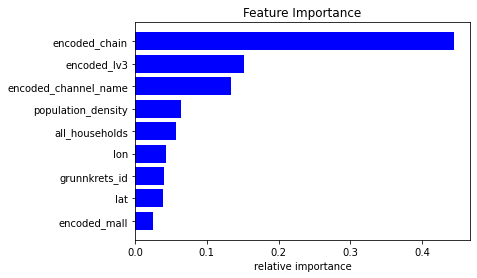

In [200]:
features = X_train.columns
importances = model1.feature_importances_
indices = np.argsort(importances)[-13:]

plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("relative importance")
plt.title("Feature Importance")
plt.show()

# Submission

In [148]:
# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()cd
submission['id'] = df_test.store_id 
submission['predicted'] = np.asarray(10 ** scaler.inverse_transform([[elmt] for elmt in model4_pred]) - 1)
#submission['predicted'] = np.asarray(10 ** avg_prediction - 1)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission_full.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,2.070407
1,916789157-916823770-824309,7.320332
2,913341082-977479363-2948,3.364804
3,889682582-889697172-28720,8.470799
4,997991699-998006945-417222,3.887988
...,...,...
8572,917323003-917383529-844309,3.098505
8573,917353379-917411824-845904,2.966489
8574,917072302-917089248-833647,3.918680
8575,916960557-916993161-829908,2.399581
